In [1]:
import numpy as np
import sys
import os
import glob
import cv2
import operator
from pylab import *
from scipy.ndimage import filters
import scipy
import transform
import imgutil
from utils import *
%matplotlib inline

In [2]:
dir_path = "parrington"
file_list = set()
extensions = ["*.jpg", "*.JPG"]

for ext in extensions:
    file_list = file_list | set(glob.glob(os.path.join(dir_path, ext)))

files = list(file_list)
files.sort()
imgs = [cv2.imread(i) for i in files]
print (files)

['parrington/prtn00.jpg', 'parrington/prtn01.jpg', 'parrington/prtn02.jpg', 'parrington/prtn03.jpg', 'parrington/prtn04.jpg', 'parrington/prtn05.jpg', 'parrington/prtn06.jpg', 'parrington/prtn07.jpg', 'parrington/prtn08.jpg', 'parrington/prtn09.jpg', 'parrington/prtn10.jpg', 'parrington/prtn11.jpg', 'parrington/prtn12.jpg', 'parrington/prtn13.jpg', 'parrington/prtn14.jpg', 'parrington/prtn15.jpg', 'parrington/prtn16.jpg', 'parrington/prtn17.jpg']


In [3]:
files = files[:6]
imgs = imgs[:6]

In [4]:
def detectAndDescribe(img):
    gray = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (5,5), 0)
    corner_response = HarrisCornerDetector(gray)
    coords = supression(corner_response)
    descriptors = gen_descriptors(gray, coords)
    return (coords, descriptors)

In [5]:
kps = []
descs = []
for i in imgs:
    kp, desc = detectAndDescribe(i)
    kps.append(kp)
    descs.append(desc)

In [6]:
inlier_list = []
homography = [np.matrix(np.identity(3))]

for i in range(len(imgs)-1):
    d1 = descs[i]
    d2 = descs[i+1]
    matches = match(d1, d2)
    print (matches.shape)
    matches1 = kps[i][matches[:, 0], 0:2]
    matches2 = kps[i+1][matches[:, 1], 0:2]
    print (matches1.shape, matches2.shape)
    data = np.hstack((matches1, matches2))
    h = imgutil.ransac(data, 0.5)
    homography.append(np.linalg.inv(h[0]))

(58, 2)
(58, 2) (58, 2)
(84, 2)
(84, 2) (84, 2)
(80, 2)
(80, 2) (80, 2)
(83, 2)
(83, 2) (83, 2)
(90, 2)
(90, 2) (90, 2)


In [7]:
mid_homography_list = []
# map all the homographies to image 1
for i in range(1, len(homography)):
    homography[i] = homography[i - 1] * homography[i]
middle = len(files) // 2
for i in range(len(homography)):
    # warp mid,  Him = Hm0^-1 * Hi0 where m is middle image
    inverse = np.linalg.inv(homography[middle])
    midHomography = inverse * homography[i]
    mid_homography_list.append(midHomography)

In [8]:
# find bounds of global extent and original picture
warpedL = []
output_range = imgutil.corners(mid_homography_list, files)[0]
midCorners = imgutil.corners(mid_homography_list, files)[1]

In [9]:
# warp the images
for i in range(len(files)):
    npimg = cv2.imread(files[i])

    # compute the gaussian weight
    h = npimg.shape[0]
    w = npimg.shape[1]
    yy, xx = np.mgrid[0:h, 0:w]
    dist = (yy - h / 2) ** 2 + (xx - w / 2) ** 2
    gwt = np.exp(-dist / (2.0 * 50.0 ** 2))

    # add the gaussian weight as the 4th channel
    npimg = np.dstack((npimg, gwt))

    # append the warped image to the list
    warpedImg = transform.transform_image(npimg, mid_homography_list[i], output_range)
    warpedL.append(warpedImg)


--------------------------------
Transforming Image
--------------------------------

transforming image...  


/home/dada/jupyter/vfx/transform.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if output_range == "auto":


done

--------------------------------
Transforming Image
--------------------------------

transforming image...  
done

--------------------------------
Transforming Image
--------------------------------

transforming image...  
done

--------------------------------
Transforming Image
--------------------------------

transforming image...  
done

--------------------------------
Transforming Image
--------------------------------

transforming image...  
done

--------------------------------
Transforming Image
--------------------------------

transforming image...  
done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


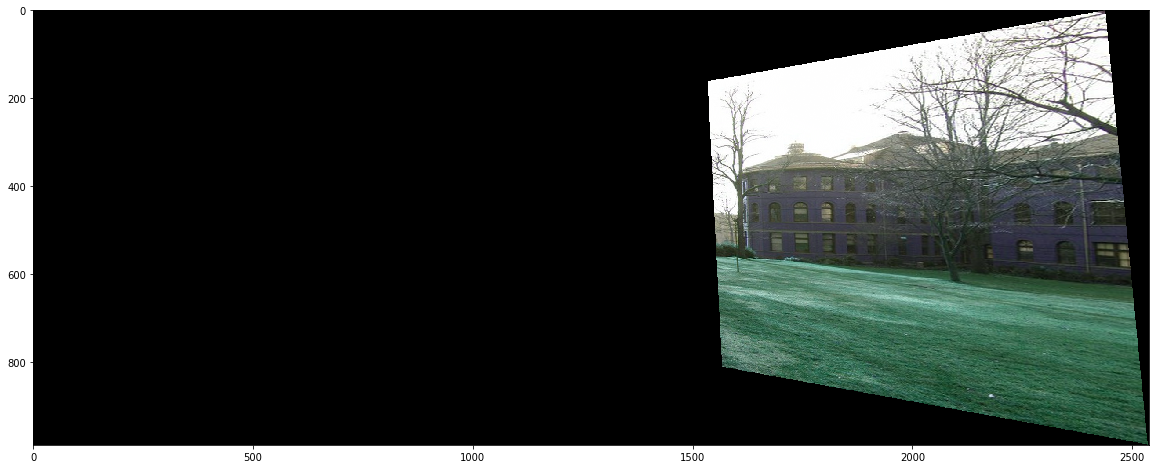

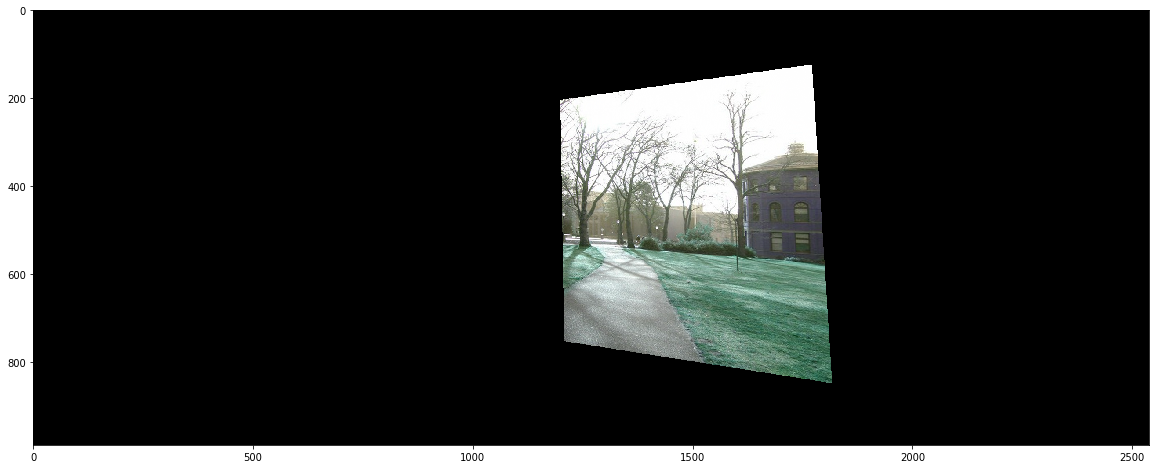

In [10]:
figure(figsize=(20, 10))
imshow(warpedL[0][:,:,:3].astype(int))
figure(figsize=(20, 10))
imshow(warpedL[1][:,:,:3].astype(int))
#cv2.imwrite('warp1.jpg', warpedL[0][:,:,:3])

In [11]:
# stitch the images
top = np.zeros(warpedL[0].shape, dtype=float)
bot = np.zeros(warpedL[0].shape, dtype=float)
bot[:, :, 3] = 1.0
for i in range(len(warpedL)):
    top[:, :, 0] += warpedL[i][:, :, 3] * warpedL[i][:, :, 0]
    top[:, :, 1] += warpedL[i][:, :, 3] * warpedL[i][:, :, 1]
    top[:, :, 2] += warpedL[i][:, :, 3] * warpedL[i][:, :, 2]
    top[:, :, 3] += warpedL[i][:, :, 3]
    bot[:, :, 0] += warpedL[i][:, :, 3]
    bot[:, :, 1] += warpedL[i][:, :, 3]
    bot[:, :, 2] += warpedL[i][:, :, 3]

bot[bot == 0] = 1

output = top / bot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

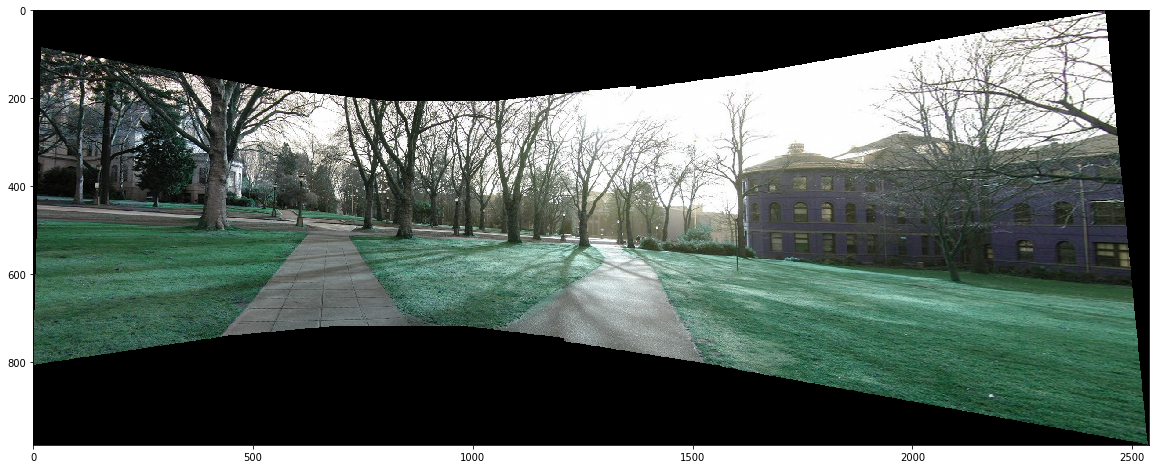

In [12]:
tmp = output.astype(int)
figure(figsize=(20,10))
imshow(tmp[:,:,:3], cmap='gray')
cv2.imwrite('output.jpg', tmp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


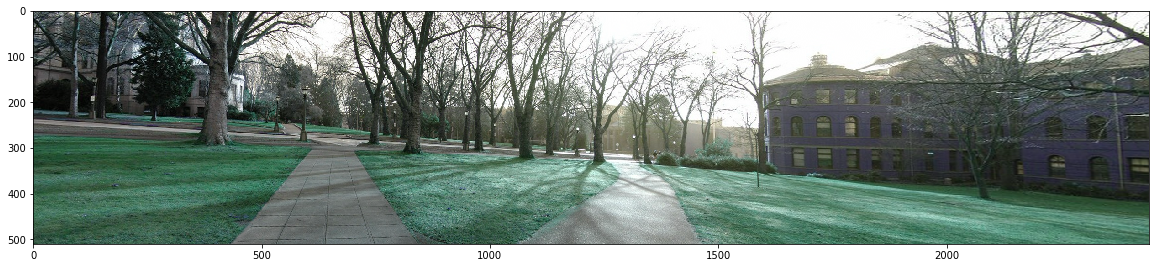

In [13]:
crop_output = imgutil.crop(output, output_range, midCorners[0:2,...])
cv2.imwrite('crop_output.png', crop_output[:,:,:3])
figure(figsize=(20,10))
imshow(crop_output[:,:,:3].astype(int), cmap='gray')

In [14]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    imshow(result)
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

In [15]:
def get_H(img1, img2):
    kp1, desc1 = detectAndDescribe(img1)
    kp2, desc2 = detectAndDescribe(img2)
    
    matches = match(desc1, desc2)
    print (matches.shape)
    
    src_pts = np.float32([ kp1[m[0]][:2] for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[1]][:2] for m in matches ]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H